In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])
from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
from matplotlib import animation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import torch
import plotly.graph_objects as go
from torch import lobpcg
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
device

device(type='cuda')

Create a meshgrid of x and y coordinates

In [4]:
N = 400
X, Y = np.mgrid[0:1:N*1j, 0:1:N*1j]

$$ H\psi = E\psi $$

$$ H\ =\ -\frac{1}{2m}\Big(\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}\Big) + V(x,y)\ \ ,\ \ \ let\ \hbar^2\ =\ 1 $$

If we discretize $\psi$ into a vector (spacing $\Delta x$), the equation $H\psi$ = $E\psi$ can be arranged and rewritten in 2 Dimensiona as :)

$$ \Big[-\frac{1}{2}(D \oplus D)\ +\ m\Delta x^2V\Big]\psi\ =\ (m\Delta x^2E)\psi $$

$ where,\ \psi$ is a vector of length $N^2$ where N is the number of discretize points in x and y

D is an N x N matrix with -2 on the main diagonal and 1 on the two neighboring diagonals.

D $\oplus$ D: the Kronecker sum of D with itself so that the derivative matrix is effectively converted to operate on a "2D" vector.

V is a diagonal $N^2$ x $N^2$ matrix with each entry on the diagonal representative of the potential at that particular coordinate.

Firstly, we define our potential in units of $m\Delta x^2$; in other words get_potential actually returns $m\Delta x^2V$

In [5]:
def get_potential(x, y):
    return np.exp(-(x-0.3)**2/(2*0.1**2)) * np.exp(-(y-0.3)**2/(2*0.1**2))

V = get_potential(X, Y)

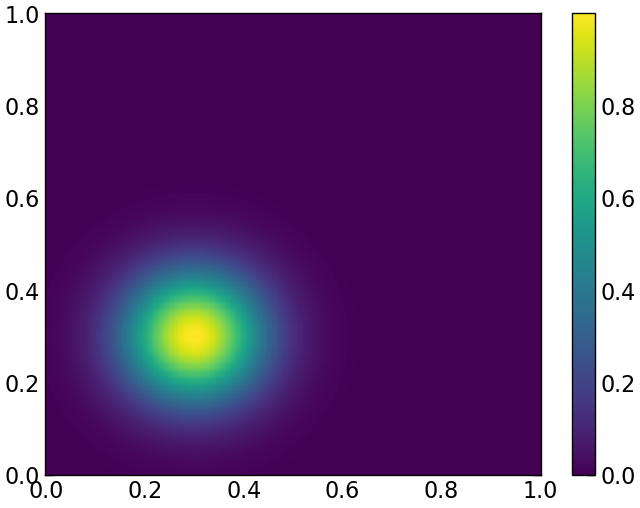

In [6]:
plt.pcolormesh(X, Y, V)
plt.colorbar()

In [7]:
diag = np.ones([N])
diags =np.array([diag, -2*diag, diag])

In [8]:
D = sparse.spdiags(diags, np.array([-1,0,1]), N, N)
T = -1/2 * sparse.kronsum(D,D)
U = sparse.diags(V.reshape(N**2), (0))
H = T + U

Convert to sparse pytorch tensor

In [9]:
H = H.tocoo()
H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]), values=torch.tensor(H.data), size=H.shape).to(device)

C:\Users\saura\AppData\Local\Temp\ipykernel_19804\2973072149.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]), values=torch.tensor(H.data), size=H.shape).to(device)


In [10]:
H

tensor(indices=tensor([[     0,      0,      0,  ..., 159999, 159999, 159999],
                       [     0,      1,    400,  ..., 159599, 159998, 159999]]),
       values=tensor([ 2.0001, -0.5000, -0.5000,  ..., -0.5000, -0.5000,
                       2.0000]),
       device='cuda:0', size=(160000, 160000), nnz=798400, dtype=torch.float64,
       layout=torch.sparse_coo)

Compute the eigenvalues and eigenvectors:

In [11]:
eigenvalues, eigenvectors = lobpcg(H, k=10, largest=False)

In [12]:
def get_E(n):
    return eigenvectors.T[n].reshape((N,N)).cpu()

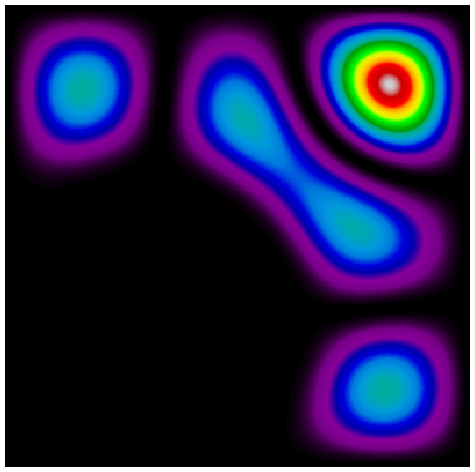

In [13]:
plt.figure(figsize=(6,6))
plt.pcolormesh(X, Y, get_E(4)**2, cmap='nipy_spectral')
plt.axis('off')
plt.show()

# Moving to 3D

The Hydrogen atom potential (choosing $\hbar$ = 1) can be expressed as

$$V(r)\ =\ -\frac{e^2}{4\pi\varepsilon_0r}\ =\ -\frac{1}{ma_0r}$$ 

and thus we can express :

$$ m\Delta x^2V\ =\ -\frac{\Delta x^2}{a_0r}\ =\ -\frac{(\Delta x/a_0)^2}{r/a_0} $$

So, expressing $\Delta x^2$ and r in units of $a_0$ such that $m\Delta x^2V$ becomes dimensionless, so we can easily plot

In [3]:
N = 120
X, Y, Z = np.mgrid[-25:25:N*1j , -25:25:N*1j, -25:25:N*1j] # in units of a0, 25 is good
dx = np.diff(X[:,0,0])[0] # in units of a0

In [4]:
dx

np.float64(0.42016806722688926)

Now, we can define Hydrogen wave function potential as $m\Delta x^2V$ = $ -\frac{(\Delta x/a_0)^2}{r/a_0}$ which is dimensionless :

In [5]:
def get_potential(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2 + 1e-10)
    return -dx**2/r

V = get_potential(X, Y, Z)

In [6]:
V.shape

(120, 120, 120)

In [7]:
120*120*120

1728000

Now, that we're in 3D, our matrix should be written as :

$$ \Big[-\frac{1}{2}(D \oplus D \oplus D)\ +\ m\Delta x^2V\Big]\psi\ =\ (m\Delta x^2E)\psi $$

In [8]:
diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])
D = sparse.spdiags(diags, np.array([-1,0,1]), N,N)
T = -1/2 * sparse.kronsum(sparse.kronsum(D,D), D)
U = sparse.diags(V.reshape(N**3), (0))
H = T + U

In [9]:
H.shape

(1728000, 1728000)

In [10]:
1728000*1728000

2985984000000

Convert to sparsh Pytorch tensor

In [11]:
H = H.tocoo()
H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]), values=torch.tensor(H.data), size=H.shape).to(device)

C:\Users\saura\AppData\Local\Temp\ipykernel_16468\2973072149.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]), values=torch.tensor(H.data), size=H.shape).to(device)


In [12]:
H

tensor(indices=tensor([[      0,       0,       0,  ..., 1727999, 1727999,
                        1727999],
                       [      0,       1,     120,  ..., 1727879, 1727998,
                        1727999]]),
       values=tensor([ 2.9959, -0.5000, -0.5000,  ..., -0.5000, -0.5000,
                       2.9959]),
       device='cuda:0', size=(1728000, 1728000), nnz=12009600,
       dtype=torch.float64, layout=torch.sparse_coo)

Compute eigenvalues/eigenvectors

In [13]:
eigenvalues, eigenvectors = lobpcg(H, k=20, largest=False)

Defining a function to get eignevectors:

In [30]:
def get_E(n):
    return eigenvectors.T[n].reshape((N,N,N)).cpu().numpy()

Compute vertices and faces corresponding to iso-surface of eigenfunction so we can show it off in 3D

In [35]:
verts, faces, _, _ = measure.marching_cubes(get_E(8)**2, 1e-6, spacing=(0.1, 0.1, 0.1))
intensity = np.linalg.norm(verts, axis=1)

In [36]:
fig = go.Figure(data=[go.Mesh3d(x=verts[:, 0], y=verts[:, 1], z=verts[:, 2],
                                
                                i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
                                intensity=intensity,
                                colorscale='Agsunset',
                                opacity=0.5)])

fig.update_layout(scene=dict(xaxis=dict(visible=False),
                            yaxis=dict(visible=False),
                            zaxis=dict(visible=False)),
                            margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [38]:
hbar = 1.055e-34
a = 5.29e-11
m = 9.11e-31
J_to_eV = 6.242e18 # convert from Joules to eV
conversion = hbar**2 / m /dx**2 / a**2 * J_to_eV

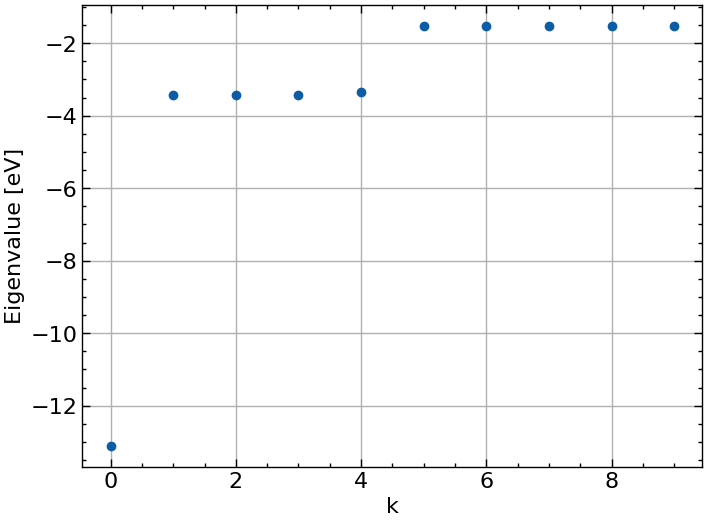

In [39]:
plt.plot(eigenvalues.cpu() * conversion, 'o')
plt.xlabel('k')
plt.ylabel('Eigenvalue [eV]')
plt.grid()

In [40]:
eigenvalues.cpu() * conversion,

(tensor([-13.1011,  -3.4247,  -3.4247,  -3.4247,  -3.3599,  -1.5176,  -1.5176,
          -1.5176,  -1.5155,  -1.5155], dtype=torch.float64),)